In [1]:
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.tri as tri
from matplotlib import ticker


In [2]:
def xy2bc(xy, tol=1.e-32):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    # Mid-points of triangle sides opposite of each corner
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0
                 for i in range(3)]

    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def bc2xy(pvalues, corners):
    return np.dot(pvalues, corners)

def get_func_mesh_values(func, subdiv=8):
    '''
    Gets the values returned by the function func in a triangular mesh grid
    '''
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    vals = np.array([func(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)])
    return vals


def get_mesh_xy(subdiv=8):
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    return zip(trimesh.x, trimesh.y)


def get_mesh_bc(**kwargs):
    mesh_xy = get_mesh_xy(**kwargs)
    mesh_bc = np.array([xy2bc(xy) for xy in mesh_xy])
    return mesh_bc


def draw_pdf_contours(dist, **kwargs):
    draw_func_contours(dist.pdf, **kwargs)


def draw_func_contours(func, labels=None, nlevels=200, subdiv=8, fig=None,
                       ax=None, grid=True, **kwargs):
    '''
    Parameters:
    -----------
    labels: None, string or list of strings
        If labels == 'auto' it shows the class number on each corner
        If labels is a list of strings it shows each string in the
        corresponding corner
        If None does not show any label
    '''
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)

    pvals = np.array([func(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)])

    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)

    # FIXME I would like the following line to work, but the max value is not
    # shown. I had to do create manually the levels and increase the max value
    # by an epsilon. This could be a major problem if the epsilon is not small
    # for the original range of values
    # contour = ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    # contour = ax.tricontourf(trimesh, pvals, nlevels, extend='both')
    contour = ax.tricontourf(trimesh, pvals,
                             levels=np.linspace(pvals.min(), pvals.max()+1e-9,
                                                nlevels),
                             **kwargs)

    # Colorbar
    cb = fig.colorbar(contour, ax=ax, fraction=0.1, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    # cb.ax.xaxis.set_major_locator(ticker.AutoLocator())
    cb.update_ticks()

    if labels is not None:
        if labels == 'auto':
            labels = [r'$C_{}$'.format(i+1) for i in range(len(corners))]
        center = corners.mean(axis=0)
        for i, corner in enumerate(corners):
            text_x, text_y = corner - (center - corner)*0.1
            ax.text(text_x, text_y, labels[i], verticalalignment='center',
                    horizontalalignment='center')

    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    if grid:
        refiner = tri.UniformTriRefiner(triangle)
        trimesh = refiner.refine_triangulation(subdiv=4)
        ax.triplot(trimesh, c='gray', lw=0.2)

    ax.triplot(triangle, c='k', lw=0.8)

    # Axes options
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylim(ymin=0, ymax=0.75**0.5)
    ax.set_xbound(lower=0, upper=1)
    ax.set_ybound(lower=0, upper=0.75**0.5)
    ax.axis('equal')
    ax.axis('off')
    plt.gca().set_adjustable("box")
    
def draw_func_contours(func, labels=None, nlevels=200, subdiv=5, fig=None,
                       ax=None, draw_lines=None, class_index=0, **kwargs):
    """
    Parameters:
    -----------
    labels: None, string or list of strings
        If labels == 'auto' it shows the class number on each corner
        If labels is a list of strings it shows each string in the
            corresponding corner
        If None does not show any label
    """
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)

    pvals = np.array([func(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)])

    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111)

    # FIXME I would like the following line to work, but the max value is
    # not shown. I had to do create manually the levels and increase the
    # max value by an epsilon. This could be a major problem if the epsilon
    # is not small for the original range of values
    # contour = ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    # contour = ax.tricontourf(trimesh, pvals, nlevels, extend='both')
    contour = ax.tricontourf(trimesh, pvals,
                             levels=np.linspace(pvals.min(), pvals.max()+1e-9,
                                                nlevels),
                             **kwargs)

    # Colorbar
    # TODO See if the following way to define the size of the bar can be used
    # from mpl_toolkits.axes_grid1 import make_axes_locatable
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("bottom", size="5%", pad=0.1)
    # cb = fig.colorbar(contour, ax=cax, orientation='horizontal')
    cb = fig.colorbar(contour, ax=ax, orientation='horizontal',
                      fraction=0.05, pad=0.06)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    # cb.ax.xaxis.set_major_locator(ticker.AutoLocator())
    cb.update_ticks()

    if labels is None:
        labels = [r'$C_{}$'.format(i+1) for i in range(len(corners))]

    center = corners.mean(axis=0)
    for i, corner in enumerate(corners):
        text_x, text_y = corner - (center - corner)*0.1
        ax.text(text_x, text_y, labels[i], verticalalignment='center',
                horizontalalignment='center')

    if draw_lines is not None:
        lines = get_converging_lines(num_lines=draw_lines, mesh_precision=2,
                                     class_index=class_index)
        corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
        for line in lines:
            line = bc2xy(line, corners).T
            ax.plot(line[0], line[1])
            # l = mlines.Line2D()
            # ax.add_line(l)

    # Axes options
    ax.set_xlim(xmin=0, xmax=1)
    ax.set_ylim(ymin=0, ymax=0.75**0.5)
    ax.set_xbound(lower=0, upper=1)
    ax.set_ybound(lower=0, upper=0.75**0.5)
    ax.axis('equal')
    ax.axis('off')

    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    ax.triplot(triangle, c='k', lw=0.5)

    plt.gca().set_adjustable("box")
    return fig

# Brier score

$$
\Psi_{MSE}(s, p) = \frac{1}{C}\sum_{i=1}^C (s_i - p_i)^2
$$

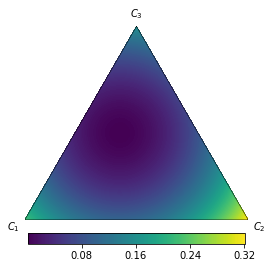

In [3]:
true_posterior = np.array([0.35, 0.2, 0.45])
def mse(s):
    return np.mean((true_posterior - s)**2)

draw_func_contours(mse);

# Cross Entropy

$$
\Psi_{CE}(s, p) = - \sum_{i=1}^C p_i \log (s_i)
$$

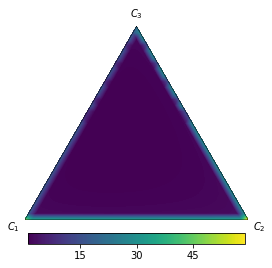

In [4]:
def ce(s):
    return -np.sum(true_posterior * np.log(s))
   
draw_func_contours(ce);

# Cross Entropy plus 0.01

$$
\Psi_{CE}(s, p) = - \sum_{i=1}^C p_i \log (0.01 + s_i)
$$

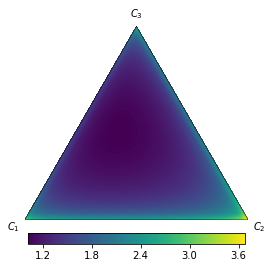

In [5]:
def ce1p(s):
    return -np.sum(true_posterior * np.log(0.01 + s))
   
draw_func_contours(ce1p);

# Optimistic Superset Loss with CE

$$
\Psi_{OSL}(s, p) = min \{ \Psi_{CE}(s_i, p) | s_i \in s \}
$$

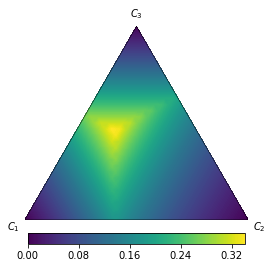

In [6]:
def osl(s):
    return np.min(-true_posterior * np.log(s))
   
draw_func_contours(osl);